In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from datetime import datetime as dt

# Load Data

In [2]:
wd = os.path.dirname('__file__')

name1 = "results_Roberta_noother.csv"
name2 = "results_BertAlbert_noother.csv"

results1 = pd.read_csv(os.path.join(wd,name1))
results2 = pd.read_csv(os.path.join(wd,name2))


results = pd.concat([results1, results2]).reset_index()

# Data Exploration

In [3]:
print(list(results.columns.values))
print(f"\n {results.shape}")

['index', 'dataset', 'model', 'learning_rate', 'batch_size', 'max_epochs', 'seed', 'best_val_accuracy', 'best_val_f1', 'best_val_loss', 'best_test_accuracy', 'best_test_f1', 'best_test_loss', 'exp_name', 'best_iter', 'total_iter', 'total_epochs']

 (40, 17)


In [13]:
spaces = {
    'learning_rate' : results['learning_rate'].unique(),
    'batch_size' : results['batch_size'].unique(),
    'max_epochs' : results['max_epochs'].unique(),
    'dataset' : results['dataset'].unique(),
}
model = {}

lr = 'learning_rate'
bs = 'batch_size'
ep = 'max_epochs'
d = 'dataset'
m = 'model'

def add_if_havent(value, l):
    if value not in l:
        l.append(value)

for label, row in results.iterrows():
    if row['model'] in model.keys():
        model[row['model']] += 1
    else:
        model[row['model']] = 1

        
print(f"Model runs {model}")

for key, value in spaces.items():
    value.sort()
    print(f"{key} {value}")

Model runs {'roberta-large': 24, 'bert-large-uncased': 10, 'albert-xxlarge-v2': 6}
learning_rate [3.e-06 5.e-06 1.e-05 3.e-05 5.e-05]
batch_size [ 8 16 32 64]
max_epochs [1 2]
dataset ['reviews_UIC']


In [14]:
scores = ['best_val_accuracy', 'best_val_f1']

model_top_scores = {}

for m in model.keys():
    print(f"Model: {m}")
    subset = results.loc[results['model']==m,:]
    temp = {}
    for score in scores:
        temp[score] = max(subset[score])
        print(f"Top {score}: {temp[score]}")
    
    model_top_scores[m] = temp
    print("")
    

Model: roberta-large
Top best_val_accuracy: 0.7345679012345679
Top best_val_f1: 0.6712962962962941

Model: bert-large-uncased
Top best_val_accuracy: 0.6990740740740741
Top best_val_f1: 0.6327160493827144

Model: albert-xxlarge-v2
Top best_val_accuracy: 0.6836419753086421
Top best_val_f1: 0.6172839506172827



In [5]:
for m in model.keys():
    temp = results.loc[results['model']==m,:]
    temp_s = {
        'learning_rate' : temp['learning_rate'].unique(),
        'batch_size' : temp['batch_size'].unique(),
        'max_epochs' : temp['max_epochs'].unique(),
        'dataset' : temp['dataset'].unique(),
    }
    
    print(f"{m}")
    for key, value in temp_s.items():
        value.sort()
        print(f"{key} {value}")
    print("")  

roberta-large
learning_rate [3.e-06 1.e-05 3.e-05 5.e-05]
batch_size [ 8 16 32 64]
max_epochs [1 2]
dataset ['reviews_UIC']

bert-large-uncased
learning_rate [5.e-06 1.e-05 3.e-05]
batch_size [ 8 16]
max_epochs [1]
dataset ['reviews_UIC']

albert-xxlarge-v2
learning_rate [5.e-06 1.e-05 3.e-05]
batch_size [ 8 16]
max_epochs [1]
dataset ['reviews_UIC']



# Analyze

In [6]:
def make_box_plots(data,
                   labels, 
                   key_frame = 'framing',
                   key_acc = 'best_val_accuracy',
                   x_size = 10,
                   y_size = 5,
                   y_min = 55,
                   y_max = 100,
                   y_tick = 15,
                   y_offset = 1,
                   x_offset = .8,
                   splines_offset = 10,
                   bar_trans = 0.3,
                   colors = ['darkgrey',
                             'gold',
                             'skyblue',
                            ],
                   bar_colors = True,
                   bar_labels = True,
                   adjusted_axes = True,
                   title = None,
                   showfliers = True,
                   notch = False,
                   translation = None,
                   ylabel = None,
                  ):
    
    all_scores = []
    max_scores = []
    for label in labels:
        dist = data.loc[data[key_frame]==label,key_acc]*100
        all_scores.append(dist)
        max_scores.append(max(dist))
    
    fig, ax = plt.subplots(figsize=(x_size, y_size))
    if not title is None:
        ax.set_title(title)
    
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    
    ax.set_ylim(y_min, y_max)
    ax.set_yticks(np.arange(y_min, y_max+1, y_tick))
    
    plot_labels = labels
    if translation is not None:
        plot_labels = []
        for label in labels:
            plot_labels.append(translation[label])
        
    ax.set_xticklabels(plot_labels)
    
    if adjusted_axes:
        # Adjust plot borders
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_position(('outward', splines_offset))
        ax.spines['bottom'].set_position(('outward', splines_offset))
    
    ticks = np.arange(len(labels))+1
    
    if not bar_colors:
        colors = None
    
    ax.bar(ticks, max_scores, color = colors, alpha=bar_trans)
    ax.boxplot(all_scores, notch = notch, showfliers = showfliers)
    
    if bar_labels:
        for i, v in enumerate(max_scores):
            ax.text(i + x_offset, v + y_offset, "{:.2f}%".format(v))
    
    # Adjust layout
    fig.tight_layout()
    
    return fig

In [7]:
def get_stats(data,
              labels,
              key_frame = 'framing',
              key_acc = 'best_val_accuracy',
             ):
    results = {label : {} for label in labels}
    
    for label, value in results.items():
        dist = data.loc[data[key_frame]==label,key_acc]
        
        value['mean'] = dist.mean()
        value['std'] = dist.std()
        value['medium'] = dist.median()
        value['1Q'] = dist.quantile(q=0.25)
        value['3Q'] = dist.quantile(q=0.75)
        value['count'] = dist.shape[0]
    
    return results

# Split by Local Minimum Stuck and Good Learning Rates

In [8]:
ordered_models = ['albert-xxlarge-v2',
                 'bert-large-uncased',
                 'roberta-large']

translation = {'albert-xxlarge-v2': 'ALBERT',
              'bert-large-uncased': 'BERT',
              'roberta-large': 'RoBERTa'}

split = 2

remove_lr = spaces['learning_rate'][-split:]

results['keep'] = results['learning_rate'].apply(lambda x: x not in remove_lr)
results['drop'] = results['learning_rate'].apply(lambda x: x in remove_lr)

results_keep = results.loc[results['keep'],:]
results_stuck = results.loc[results['drop'],:]

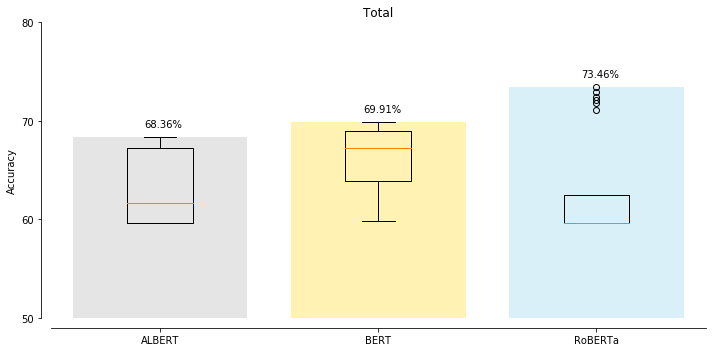

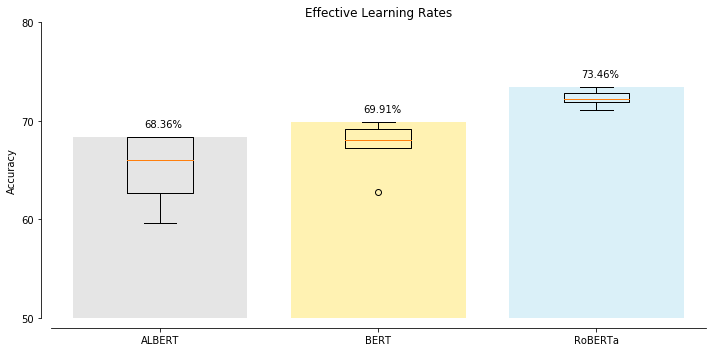

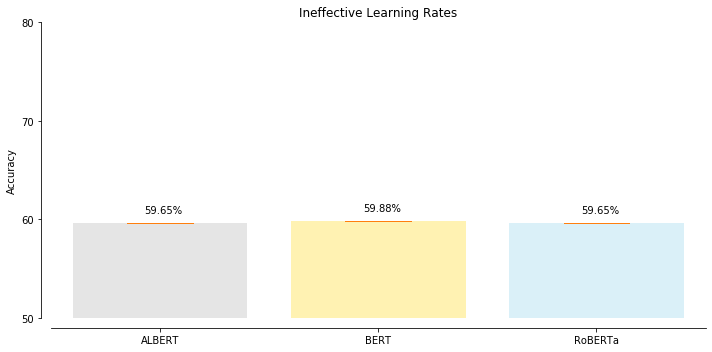

In [9]:
x_offset = 0.93
y_min = 50
y_max = 80
y_tick = 10
ylabel = 'Accuracy'
key_frame = 'model'
key_acc = 'best_val_accuracy'


f_total = make_box_plots(results,
                       ordered_models,
                       title = 'Total',
                       key_frame = key_frame,
                       key_acc = key_acc,
                       y_min = y_min,
                       y_max = y_max,
                       y_tick = y_tick,
                       x_offset = x_offset,
                       bar_colors = True,
                       bar_labels = True,
                       adjusted_axes = True,
                       showfliers = True,
                       notch = False,
                       translation = translation,
                       ylabel = ylabel,
                      )

f_keep = make_box_plots(results_keep,
                       ordered_models,
                       title = 'Effective Learning Rates',
                       key_frame = key_frame,
                       key_acc = key_acc,
                       y_min = y_min,
                       y_max = y_max,
                       y_tick = y_tick,
                       x_offset = x_offset,
                       bar_colors = True,
                       bar_labels = True,
                       adjusted_axes = True,
                       showfliers = True,
                       notch = False,
                       translation = translation,
                       ylabel = ylabel,
                      )

f_stuck = make_box_plots(results_stuck,
                       ordered_models,
                       title = 'Ineffective Learning Rates',
                       key_frame = key_frame,
                       key_acc = key_acc,
                       y_min = y_min,
                       y_max = y_max,
                       y_tick = y_tick,
                       x_offset = x_offset,
                       bar_colors = True,
                       bar_labels = True,
                       adjusted_axes = True,
                       showfliers = True,
                       notch = False,
                       translation = translation,
                       ylabel = ylabel,
                      )

In [10]:
key_frame = 'model'
key_acc = 'best_val_accuracy'
ordered_models = ['albert-xxlarge-v2',
                 'bert-large-uncased',
                 'roberta-large']

stats_total = get_stats(results,
                        ordered_models,
                        key_frame = key_frame,
                        key_acc = key_acc,
                       )

stats_keep = get_stats(results_keep,
                        ordered_models,
                        key_frame = key_frame,
                        key_acc = key_acc,
                       )

stats_stuck = get_stats(results_stuck,
                        ordered_models,
                        key_frame = key_frame,
                        key_acc = key_acc,
                       )

stats = {'total':stats_total, 'keep':stats_keep, 'stuck':stats_stuck}

for key, value in stats.items():
    print(f"{key}")
    for m, stat in value.items():
        print(f"{m}: {stat}")
    print("")

total
albert-xxlarge-v2: {'mean': 0.6323302469135802, 'std': 0.042785476432996995, 'medium': 0.6168981481481481, '1Q': 0.5964506172839507, '3Q': 0.672067901234568, 'count': 6}
bert-large-uncased: {'mean': 0.6618827160493828, 'std': 0.03905198559994804, 'medium': 0.6728395061728395, '1Q': 0.6386959876543209, '3Q': 0.689236111111111, 'count': 10}
roberta-large: {'mean': 0.6280864197530864, 'std': 0.05610867448873046, 'medium': 0.5964506172839507, '1Q': 0.5964506172839507, '3Q': 0.625, 'count': 24}

keep
albert-xxlarge-v2: {'mean': 0.6502700617283951, 'std': 0.041995799396743284, 'medium': 0.6604938271604939, '1Q': 0.6271219135802469, '3Q': 0.6836419753086421, 'count': 4}
bert-large-uncased: {'mean': 0.677662037037037, 'std': 0.023194948281375583, 'medium': 0.6801697530864197, '1Q': 0.6728395061728395, '3Q': 0.6921296296296295, 'count': 8}
roberta-large: {'mean': 0.7229938271604938, 'std': 0.00835331395229899, 'medium': 0.722608024691358, '1Q': 0.7191358024691358, '3Q': 0.7278163580246914

# Save Stuff

In [11]:
wd = os.path.dirname('__file__')
now = dt.now().strftime("%Y%m%d_%H%M")
PRE = 'Text-Only'

plots = {"total":f_total, "keep":f_keep, "stuck":f_stuck}
stats = {"total":stats_total, "keep":stats_keep, "stuck":stats_stuck}

plot_names = {key:os.path.join(wd, f"{PRE}_{key}_plot_{now}.png") for key in plots.keys()}

stats_names = {key:os.path.join(wd, f"{PRE}_{key}_stats_{now}.json") for key in stats.keys()}

for key in plots.keys():
    plots[key].savefig(plot_names[key])
    with open(stats_names[key], 'w') as f:
        f.write(json.dumps(stats[key]))